In [1]:
seed = 0
import random
import numpy as np
import tensorflow as tf
import os
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
os.environ["CUDA_DEVICE_ORDER"] = 'PCI_BUS_ID'
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
os.environ["PYTHONHASHSEED"] = str(seed)

os.environ['TF_DETERMINISTIC_OPS'] = '1'


gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=7000)])
    except RuntimeError as e:
        print(e)

In [2]:
import numpy as np
import pandas as pd
# 选择比较好的模型
import seaborn as sns

import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.signal import resample
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import os
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

from sklearn.preprocessing import StandardScaler,MinMaxScaler
%load_ext autoreload
%autoreload 2

def acc_combo(y, y_pred):
    # 数值ID与行为编码的对应关系
    mapping = {
        0: 'A_1', 1: 'B_2', 2: 'A_3', 3: 'A_4', 4: 'B_3', 5: 'C_5', 6: 'C_2', 7: 'A_5', 8: 'B_1', 
        9: 'C_1', 10: 'A_2', 11: 'C_3',12: 'B_5', 13: 'B_4', 14: 'C_4', 
        15: 'D_6', 16: 'E_7', 17: 'F_8', 18: 'G_9', 19: 'H_0'
              }
    # 将行为ID转为编码
    code_y, code_y_pred = mapping[y], mapping[y_pred]
    if code_y == code_y_pred: #编码完全相同得分1.0
        return 1.0
    elif code_y.split("_")[0] == code_y_pred.split("_")[0]: #编码仅字母部分相同得分1.0/7
        return 1.0/7
    elif code_y.split("_")[1] == code_y_pred.split("_")[1]: #编码仅数字部分相同得分1.0/3
        return 1.0/3
    else:
        return 0.0
    
    
# def acc_combo(y, y_pred):
#     # 数值ID与行为编码的对应关系
#     mapping = {0: 'A_0', 1: 'A_1', 2: 'A_2', 3: 'A_3', 
#         4: 'D_4', 5: 'A_5', 6: 'B_1',7: 'B_5', 
#         8: 'B_2', 9: 'B_3', 10: 'B_0', 11: 'A_6', 
#         12: 'C_1', 13: 'C_3', 14: 'C_0', 15: 'B_6', 
#         16: 'C_2', 17: 'C_5', 18: 'C_6'}
#     # 将行为ID转为编码
#     code_y, code_y_pred = mapping[y], mapping[y_pred]
#     if code_y == code_y_pred: #编码完全相同得分1.0
#         return 1.0
#     elif code_y.split("_")[0] == code_y_pred.split("_")[0]: #编码仅字母部分相同得分1.0/7
#         return 1.0/7
#     elif code_y.split("_")[1] == code_y_pred.split("_")[1]: #编码仅数字部分相同得分1.0/3
#         return 1.0/3
#     else:
#         return 0.0


sample_num = 60

In [3]:
!ls ../../data/final_data

sensor_test_final.csv  sensor_train_final.csv  submit_example.csv


In [4]:
root_path  = '../../data/final_data/'
train = pd.read_csv(root_path+'sensor_train_final.csv')
test = pd.read_csv(root_path+'sensor_test_final.csv')
sub = pd.read_csv(root_path+'submit_example.csv')
y = train.groupby('fragment_id')['behavior_id'].min()
# data_test['fragment_id'] += 100000
label = 'behavior_id'

In [5]:

def add_features(df):
    print(df.columns)
    df['acc'] = (df.acc_x ** 2 + df.acc_y ** 2 + df.acc_z ** 2) ** .5
    df['xy'] = (df['acc_x'] ** 2 + df['acc_y'] ** 2) ** 0.5
    
    df['accg'] = (df.acc_xg ** 2 + df.acc_yg ** 2 + df.acc_zg ** 2) ** .5
    df['xy_g'] = (df['acc_xg'] ** 2 + df['acc_yg'] ** 2) ** 0.5 
    
    
    df['thetax']=np.arctan(df.acc_xg/
                           np.sqrt(df.acc_yg*df.acc_yg+df.acc_zg*df.acc_zg))*180/np.pi
    df['thetay']=np.arctan(df.acc_yg/
                           np.sqrt(df.acc_xg*df.acc_xg+df.acc_zg*df.acc_zg))*180/np.pi
    df['thetaz']=np.arctan(df.acc_zg/
                           np.sqrt(df.acc_yg*df.acc_yg+df.acc_xg*df.acc_xg))*180/np.pi
    
    df['g'] = ((df["acc_x"] - df["acc_xg"]) ** 2 + 
                 (df["acc_y"] - df["acc_yg"]) ** 2 + (df["acc_z"] - df["acc_zg"]) ** 2) ** 0.5

    print(df.columns)
    return df


train=add_features(train)
test=add_features(test)

Index(['fragment_id', 'time_point', 'acc_x', 'acc_y', 'acc_z', 'acc_xg',
       'acc_yg', 'acc_zg', 'behavior_id'],
      dtype='object')
Index(['fragment_id', 'time_point', 'acc_x', 'acc_y', 'acc_z', 'acc_xg',
       'acc_yg', 'acc_zg', 'behavior_id', 'acc', 'xy', 'accg', 'xy_g',
       'thetax', 'thetay', 'thetaz', 'g'],
      dtype='object')
Index(['fragment_id', 'time_point', 'acc_x', 'acc_y', 'acc_z', 'acc_xg',
       'acc_yg', 'acc_zg'],
      dtype='object')
Index(['fragment_id', 'time_point', 'acc_x', 'acc_y', 'acc_z', 'acc_xg',
       'acc_yg', 'acc_zg', 'acc', 'xy', 'accg', 'xy_g', 'thetax', 'thetay',
       'thetaz', 'g'],
      dtype='object')


In [6]:
train.describe()

,fragment_id,time_point,acc_x,acc_y,acc_z,acc_xg,acc_yg,acc_zg,behavior_id,acc,xy,accg,xy_g,thetax,thetay,thetaz,g
count,391794.000000,391794.000000,391794.000000,391794.000000,391794.000000,391794.000000,391794.000000,391794.000000,391794.000000,391794.000000,391794.000000,391794.000000,391794.000000,391794.000000,391794.000000,391794.000000,391794.000000
mean,7476.755147,1379.682838,-0.009284,-0.171336,0.014685,0.684638,3.413824,7.014268,9.875366,0.745027,0.476640,9.780786,4.806181,4.556521,23.021800,52.636211,9.773486
std,4330.938746,1049.440947,0.415241,0.683727,0.948553,2.820369,3.135597,4.136285,5.879332,1.007100,0.664953,0.744531,2.609592,18.801977,23.130714,31.541102,0.286256
min,0.000000,0.000000,-16.120000,-8.040000,-23.160000,-11.630000,-9.250000,-13.330000,0.000000,0.000000,0.000000,1.772597,0.000000,-89.486065,-64.964977,-82.734104,2.204745
25%,3693.000000,552.000000,-0.100000,-0.190000,-0.200000,-0.670000,0.610000,6.460000,5.000000,0.141421,0.100000,9.560073,2.476954,-3.886956,3.569773,41.918009,9.667559
50%,7482.000000,1145.000000,-0.000000,0.000000,0.000000,0.030000,3.060000,8.390000,10.000000,0.343657,0.214709,9.749872,4.773395,0.175579,17.495758,59.791002,9.774428
75%,11228.000000,1973.000000,0.100000,0.070000,0.190000,1.210000,6.130000,9.420000,15.000000,0.868389,0.582580,9.943449,6.953799,7.192069,39.926225,75.273684,9.854207
max,14999.000000,4999.000000,7.610000,8.580000,11.180000,18.540000,13.060000,48.570000,19.000000,23.263863,16.149158,48.572835,18.865622,89.821879,89.917486,90.000000,60.917291


In [7]:

group1 = [x for x in train.columns if x not in ['fragment_id', 'time_point','behavior_id']]
# group1 = ["acc_x","acc_y","acc_z","acc","acc_xg","acc_yg","acc_zg","accg"]


test['fragment_id'] += 15000
data = pd.concat([train, test], sort=False)
ss_tool = StandardScaler()
data[group1] = ss_tool.fit_transform(data[group1])


train = data[data["behavior_id"].isna()==False].reset_index(drop=True)
test = data[data["behavior_id"].isna()==True].reset_index(drop=True)
test['fragment_id'] -= 15000



In [8]:
group1 = [x for x in train.columns if x not in ['fragment_id', 'time_point','behavior_id']]
group1

['acc_x',
 'acc_y',
 'acc_z',
 'acc_xg',
 'acc_yg',
 'acc_zg',
 'acc',
 'xy',
 'accg',
 'xy_g',
 'thetax',
 'thetay',
 'thetaz',
 'g']

In [9]:
FEATURE_NUM=len(group1)

In [10]:

x = np.zeros((15000, sample_num, FEATURE_NUM, 1))
t = np.zeros((16000, sample_num, FEATURE_NUM, 1))

# from scipy.fftpack import fft
# from scipy.signal import resample
# def get_fft_values(y_values, N, f_s):
#     f_values = np.linspace(0.0, f_s/2.0, N//2)
#     fft_values_ = fft(y_values)
#     plt.plot(fft_values_)
#     plt.show()
#     print(fft_values_.shape)
#     fft_values = 2.0/N * np.abs(fft_values_[0:N//2])
#     print(fft_values.shape)
#     return f_values, fft_values

# tmp = train[train.fragment_id == 0][:sample_num]

# get_fft_values(tmp["acc"].values,60,5)

In [11]:
def df2array(df,num,x):
    for i in tqdm(range(num)):
        tmp = df[df.fragment_id == i][:sample_num]
        length=len(tmp)
        if length<50:
            new_tmp=tmp.copy()
            while len(tmp)<60:
                new_tmp['time_point']=tmp['time_point'].max()+new_tmp['time_point']
                tmp=pd.concat([tmp,new_tmp],ignore_index=True)
        x[i,:,:,0] = resample(tmp[group1], sample_num, np.array(tmp.time_point))[0].reshape(sample_num,FEATURE_NUM)
    return x
x=df2array(train,15000,x)
t=df2array(test,16000,t)



100%|██████████| 16000/16000 [00:49<00:00, 325.08it/s]


In [12]:
%%time
# 一个完成了的generator
def data_generator(data,label,class17label,batch_size):
    """
    data:array  (7292, 60, 14, 1)
    label:array (7292,)
    class17label: series
    """
    class17label=np.asarray(class17label)
    length=len(data)
    seq_length=len(data[0])
    half_seq_length=int(seq_length/2)
    
    # index2label
    index2label=dict(zip(range(length),class17label))
    
    label2index={}
#     print(class17label)
    for i in range(length):
#         print(class17label[i],label2index.get(class17label[i],[]))
        label2index[class17label[i]]=label2index.get(class17label[i],[])
        label2index[class17label[i]].append(i)

    count=0
    np.random.seed(seed)# 保证结果可重复
    
    while True:
        
        if count==0 or (count + 1) * batch_size > length:  # 如果是第一个或者最后一个batch
            count=0
            shuffle_index = list(range(length))
            np.random.shuffle(shuffle_index)   ## 对索引进行打乱
        
        start = count * batch_size  ## batch的起始点
        end = (count + 1) * batch_size ## batch的终点
        inds=shuffle_index[start:end]

        count+=1
        
        if random.choice([0,1,1,1]):
            # minxup
            #one specific index -> label -> all the index belong to this
            choice_index=[random.choice(label2index[index2label[x]]) for x in inds]   # get the random choice seq(waiting for concat)
            # 1st 前1/2 seq_length 点原始  后1/2 seq_length 点随机
            res_x_orig=data[inds,:half_seq_length]   #原始
            res_x=data[choice_index,half_seq_length:]   #需要加入的

    #         print(inds)
    #         print(data.shape,res_x_orig.shape,res_x.shape,np.concatenate((res_x_orig,res_x),axis=1).shape)
#             yield np.concatenate((res_x_orig,res_x),axis=1),\
#                     [label[0][inds],label[1][inds],label[2][inds]]
            yield np.concatenate((res_x_orig,res_x),axis=1),label[inds]
        else:
        
            yield data[inds],label[inds]
            
    

count=0
for a,b in data_generator(x,y,y,32):
    print(a.shape,b.shape)
    count+=1
    if count==20:
        break


(32, 60, 14, 1) (32,)
(32, 60, 14, 1) (32,)
(32, 60, 14, 1) (32,)
(32, 60, 14, 1) (32,)
(32, 60, 14, 1) (32,)
(32, 60, 14, 1) (32,)
(32, 60, 14, 1) (32,)
(32, 60, 14, 1) (32,)
(32, 60, 14, 1) (32,)
(32, 60, 14, 1) (32,)
(32, 60, 14, 1) (32,)
(32, 60, 14, 1) (32,)
(32, 60, 14, 1) (32,)
(32, 60, 14, 1) (32,)
(32, 60, 14, 1) (32,)
(32, 60, 14, 1) (32,)
(32, 60, 14, 1) (32,)
(32, 60, 14, 1) (32,)
(32, 60, 14, 1) (32,)
(32, 60, 14, 1) (32,)
CPU times: user 26.6 ms, sys: 2.02 ms, total: 28.6 ms
Wall time: 26.2 ms


In [13]:
# %%time
# # 一个完成了的generator
# def data_generator(data,label,class17label,batch_size):
#     """
#     data:array  (7292, 60, 14, 1)
#     label:array (7292,)
#     class17label: series
#     """
#     class17label=np.asarray(class17label)
#     length=len(data)
#     seq_length=len(data[0])
#     half_seq_length=int(seq_length/2)
    
#     # index2label
#     index2label=dict(zip(range(length),class17label))
    
#     label2index={}
# #     print(class17label)
#     for i in range(length):
# #         print(class17label[i],label2index.get(class17label[i],[]))
#         label2index[class17label[i]]=label2index.get(class17label[i],[])
#         label2index[class17label[i]].append(i)

#     count=0
#     np.random.seed(seed)# 保证结果可重复
    
#     while True:
        
#         if count==0 or (count + 1) * batch_size > length:  # 如果是第一个或者最后一个batch
#             count=0
#             shuffle_index = list(range(length))
#             np.random.shuffle(shuffle_index)   ## 对索引进行打乱
        
#         start = count * batch_size  ## batch的起始点
#         end = (count + 1) * batch_size ## batch的终点
#         inds=shuffle_index[start:end]

#         count+=1
        
#         if random.choice([0,1,1,1]):
#             # minxup
#             #one specific index -> label -> all the index belong to this
#             choice_index=[random.choice(label2index[index2label[x]]) for x in inds]   # get the random choice seq(waiting for concat)
#             # 1st 前1/2 seq_length 点原始  后1/2 seq_length 点随机
#             res_x_orig=data[inds,:half_seq_length]   #原始
#             res_x=data[choice_index,half_seq_length:]   #需要加入的

#     #         print(inds)
#     #         print(data.shape,res_x_orig.shape,res_x.shape,np.concatenate((res_x_orig,res_x),axis=1).shape)
#             yield np.concatenate((res_x_orig,res_x),axis=1),\
#                     [label[0][inds],label[1][inds],label[2][inds]]
#         else:
        
#             yield data[inds],[label[0][inds],label[1][inds],label[2][inds]]
            
    

# count=0
# for a,b in data_generator(x,[y,y,y],y,32):
#     print(a.shape,b[0].shape)
#     count+=1
#     if count==20:
#         break


In [14]:

def LSTM_A(INPUT,INPUT_SIZE = 8,CELL_SIZE = 64):
    TIME_STEPS = 60
    OUTPUT_SIZE = 19
    
    activateion_fun = 'tanh'
#     inputs = Input(shape=[TIME_STEPS,INPUT_SIZE])
    x = LSTM(CELL_SIZE, input_shape = (TIME_STEPS,INPUT_SIZE), return_sequences=True, activation=activateion_fun)(INPUT)
    x = LayerNormalization()(x)
    x = Dropout(0.2)(x)
    x = LSTM(CELL_SIZE, input_shape = (TIME_STEPS,CELL_SIZE), return_sequences=True,activation=activateion_fun)(x)
    x = LayerNormalization()(x)
#     x = Attention()([x,x])
    x = Dropout(0.3)(x)
    x = LSTM(CELL_SIZE, input_shape = (TIME_STEPS,CELL_SIZE), return_sequences=True)(x)
#     x = Attention()([x,x])   # 现在改的
    x = LayerNormalization()(x)
    x = Dropout(0.5)(x)
    x = GlobalAveragePooling1D()(x)   
    return x

def LSTM_Model():
    
    TIME_STEPS = 60
    INPUT_SIZE = len(group1)
    OUTPUT_SIZE = 19
    activateion_fun = 'tanh'
    INPUT = Input(shape=[TIME_STEPS,INPUT_SIZE])
    part = tf.split(INPUT,axis=2, num_or_size_splits = [3,3,2,2,3,1])
    A = LSTM_A(INPUT,CELL_SIZE = 32)
    A1 = LSTM_A(part[0],3,CELL_SIZE = 16)
    A2 = LSTM_A(part[1],3,CELL_SIZE = 16)
    A3 = LSTM_A(part[2],2,CELL_SIZE = 16)
    A4 = LSTM_A(part[3],2,CELL_SIZE = 16)
    A5 = LSTM_A(part[4],3,CELL_SIZE = 16)
    A6 = LSTM_A(part[5],1,CELL_SIZE = 16)
    
    x = Concatenate()([A,A1,A2,A3,A4,A5,A6])
    x = BatchNormalization()(x)
    x = Dense(256, activation='relu')(x)
    X = BatchNormalization()(x)
#     X = Dropout(0.5)(X)

    X = Dense(64)(X)

    X = Dense(64)(X)
    output3 = Dense(20, activation='softmax',name='19class')(X) #小类
    print(output3.shape)
    return Model(INPUT, output3)

LSTM_Model().summary()

(None, 20)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60, 14)]     0                                            
__________________________________________________________________________________________________
tf_op_layer_split (TensorFlowOp [(None, 60, 3), (Non 0           input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 60, 32)       6016        input_1[0][0]                    
__________________________________________________________________________________________________
lstm_3 (LSTM)                   (None, 60, 16)       1280        tf_op_layer_split[0][0]          
___________________________________________________________________________________

In [15]:
# [:,:,:,[1]]
train = x
test = t

fold_num=5
kfold = StratifiedKFold(fold_num,random_state=42,shuffle=True)
proba_t = np.zeros((16000, 20))
proba_oof = np.zeros((15000, 20))

oof_score = []
oof_comm = []
history = []

from tensorflow.keras.losses import categorical_crossentropy
def custom_loss(y_true, y_pred):
    return categorical_crossentropy(y_true, y_pred, label_smoothing=0.05)

# 两个输出    

mapping = {
        0: 'A_1', 1: 'B_2', 2: 'A_3', 3: 'A_4', 4: 'B_3', 5: 'C_5', 6: 'C_2', 7: 'A_5', 8: 'B_1', 
        9: 'C_1', 10: 'A_2', 11: 'C_3',12: 'B_5', 13: 'B_4', 14: 'C_4', 
        15: 'D_6', 16: 'E_7', 17: 'F_8', 18: 'G_9', 19: 'H_0'
              }

# # 每一个大类输出 4
# new_mapping = {'A':0,'B':1,'C':2,'D':3}
# y_1 = to_categorical([new_mapping[mapping[x][0]] for x in y], num_classes=4)
# # 每一个大类输出 
# new_mapping = {'A':0,'B':1,'C':2,'D':3}
# y_2 = to_categorical([mapping[x][2] for x in y], num_classes=7)
# 每一个小类的输出 19

y_binary = to_categorical(y)

seeds = [42,39,17][:1]
for seed in seeds:
    kfold = StratifiedKFold(fold_num,random_state=seed,shuffle=True)
    for fold, (xx, yy) in enumerate(kfold.split(train, y)):
        print(train.shape)
        mapping = {
        0: 'A_1', 1: 'B_2', 2: 'A_3', 3: 'A_4', 4: 'B_3', 5: 'C_5', 6: 'C_2', 7: 'A_5', 8: 'B_1', 
        9: 'C_1', 10: 'A_2', 11: 'C_3',12: 'B_5', 13: 'B_4', 14: 'C_4', 
        15: 'D_6', 16: 'E_7', 17: 'F_8', 18: 'G_9', 19: 'H_0'
              }
        new_mapping = {'A':0,'B':1,'C':2,'D':3}

        model = LSTM_Model()
        model.summary()
#         optimizer = AdamW(learning_rate=lr_schedule(0), weight_decay=wd_schedule(0))
#         lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)
#         wd_callback = WeightDecayScheduler(wd_schedule)
        model.compile(loss=custom_loss,
#                       ,loss_weights=[3,7,21],
                      optimizer=Adam(),
                      metrics=["acc"])#'',localscore
        plateau = ReduceLROnPlateau(monitor="val_acc",
                                    verbose=1,
                                    mode='max',
                                    factor=0.5,
                                    patience=18)
        early_stopping = EarlyStopping(monitor="val_acc",
                                       verbose=1,
                                       mode='max',
                                       patience=60)

        checkpoint = ModelCheckpoint(f'LSTM{fold}.h5',
                                     monitor="val_acc",
                                     verbose=0,
                                     mode='max',
                                     save_best_only=True)

        train_res = model.fit(train[xx][:,:,:,0], y_binary[xx],
                  epochs=400,
                  batch_size=256,
                  verbose=1,
                  shuffle=True,
                  validation_data=(train[yy][:,:,:,0], y_binary[yy]),
                  callbacks=[plateau, early_stopping, checkpoint],
#                              class_weight=[classweights1,classweights2,classweights3]
                             )
        history.append(train_res)
        
        model.load_weights(f'LSTM{fold}.h5')
        proba_t[:,:20] += model.predict(test[:,:,:,0], verbose=0, batch_size=1024) / fold_num /len(seeds)
        proba_oof[yy,:20] += model.predict(train[yy][:,:,:,0],verbose=0,batch_size=1024)/len(seeds)


        oof_y = np.argmax(proba_oof[yy,:20], axis=1)
        acc = round(accuracy_score(y[yy], oof_y),3)
        print(acc)
        oof_score.append(acc)
        scores = sum(acc_combo(y_true, y_pred) for y_true, y_pred in zip(y[yy], oof_y)) / oof_y.shape[0]
        oof_comm.append(scores)   
        print(round(scores, 5))


(15000, 60, 14, 1)
(None, 20)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 60, 14)]     0                                            
__________________________________________________________________________________________________
tf_op_layer_split_1 (TensorFlow [(None, 60, 3), (Non 0           input_2[0][0]                    
__________________________________________________________________________________________________
lstm_21 (LSTM)                  (None, 60, 32)       6016        input_2[0][0]                    
__________________________________________________________________________________________________
lstm_24 (LSTM)                  (None, 60, 16)       1280        tf_op_layer_split_1[0][0]        
______________________________________________________________

12000/12000 [==============================] - 46s 4ms/sample - loss: 1.8560 - acc: 0.4717 - val_loss: 1.7058 - val_acc: 0.5067
Epoch 2/400
12000/12000 [==============================] - 6s 490us/sample - loss: 1.3535 - acc: 0.6168 - val_loss: 1.4254 - val_acc: 0.6080
Epoch 3/400
12000/12000 [==============================] - 6s 492us/sample - loss: 1.2204 - acc: 0.6700 - val_loss: 1.2315 - val_acc: 0.6867
Epoch 4/400
12000/12000 [==============================] - 5s 442us/sample - loss: 1.1494 - acc: 0.6910 - val_loss: 1.1593 - val_acc: 0.6963
Epoch 5/400
12000/12000 [==============================] - 6s 486us/sample - loss: 1.0982 - acc: 0.7163 - val_loss: 1.0966 - val_acc: 0.7137
Epoch 6/400
12000/12000 [==============================] - 6s 461us/sample - loss: 1.0460 - acc: 0.7344 - val_loss: 1.1226 - val_acc: 0.7083
Epoch 7/400
12000/12000 [==============================] - 5s 445us/sample - loss: 1.0095 - acc: 0.7495 - val_loss: 1.0676 - val_acc: 0.7240
Epoch 8/400
12000/12000 [=

Epoch 59/400
12000/12000 [==============================] - 6s 476us/sample - loss: 0.5397 - acc: 0.9464 - val_loss: 1.0185 - val_acc: 0.7910
Epoch 60/400
12000/12000 [==============================] - 5s 440us/sample - loss: 0.5297 - acc: 0.9513 - val_loss: 1.0072 - val_acc: 0.8060
Epoch 61/400
12000/12000 [==============================] - 6s 479us/sample - loss: 0.5314 - acc: 0.9492 - val_loss: 1.0150 - val_acc: 0.7943
Epoch 62/400
12000/12000 [==============================] - 6s 475us/sample - loss: 0.5342 - acc: 0.9481 - val_loss: 1.0209 - val_acc: 0.7887
Epoch 63/400
12000/12000 [==============================] - 5s 422us/sample - loss: 0.5310 - acc: 0.9498 - val_loss: 1.0339 - val_acc: 0.7917
Epoch 64/400
12000/12000 [==============================] - 6s 478us/sample - loss: 0.5252 - acc: 0.9503 - val_loss: 1.0038 - val_acc: 0.8003
Epoch 65/400
12000/12000 [==============================] - 6s 477us/sample - loss: 0.5271 - acc: 0.9513 - val_loss: 1.0221 - val_acc: 0.7940
Epoch 

11776/12000 [============================>.] - ETA: 0s - loss: 0.4448 - acc: 0.9842
Epoch 00115: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
12000/12000 [==============================] - 6s 467us/sample - loss: 0.4449 - acc: 0.9842 - val_loss: 1.0021 - val_acc: 0.8090
Epoch 116/400
12000/12000 [==============================] - 6s 478us/sample - loss: 0.4364 - acc: 0.9877 - val_loss: 0.9957 - val_acc: 0.8037
Epoch 117/400
12000/12000 [==============================] - 5s 434us/sample - loss: 0.4330 - acc: 0.9879 - val_loss: 0.9915 - val_acc: 0.8090
Epoch 118/400
12000/12000 [==============================] - 6s 463us/sample - loss: 0.4326 - acc: 0.9888 - val_loss: 0.9924 - val_acc: 0.8107
Epoch 119/400
12000/12000 [==============================] - 6s 479us/sample - loss: 0.4314 - acc: 0.9900 - val_loss: 0.9951 - val_acc: 0.8093
Epoch 120/400
12000/12000 [==============================] - 5s 439us/sample - loss: 0.4301 - acc: 0.9899 - val_loss: 0.9909 - val_acc:

Epoch 169/400
12000/12000 [==============================] - 5s 455us/sample - loss: 0.4158 - acc: 0.9935 - val_loss: 1.0007 - val_acc: 0.8083
Epoch 170/400
12000/12000 [==============================] - 6s 484us/sample - loss: 0.4157 - acc: 0.9941 - val_loss: 1.0000 - val_acc: 0.8063
Epoch 171/400
12000/12000 [==============================] - 5s 451us/sample - loss: 0.4148 - acc: 0.9942 - val_loss: 0.9988 - val_acc: 0.8090
Epoch 172/400
12000/12000 [==============================] - 5s 448us/sample - loss: 0.4141 - acc: 0.9948 - val_loss: 0.9983 - val_acc: 0.8093
Epoch 173/400
12000/12000 [==============================] - 6s 480us/sample - loss: 0.4176 - acc: 0.9942 - val_loss: 1.0002 - val_acc: 0.8070
Epoch 174/400
12000/12000 [==============================] - 5s 458us/sample - loss: 0.4153 - acc: 0.9933 - val_loss: 0.9969 - val_acc: 0.8087
Epoch 175/400
12000/12000 [==============================] - 5s 447us/sample - loss: 0.4149 - acc: 0.9946 - val_loss: 1.0005 - val_acc: 0.8083

12000/12000 [==============================] - 43s 4ms/sample - loss: 1.8058 - acc: 0.4734 - val_loss: 1.6960 - val_acc: 0.5060
Epoch 2/400
12000/12000 [==============================] - 6s 496us/sample - loss: 1.3515 - acc: 0.6177 - val_loss: 1.4007 - val_acc: 0.6283
Epoch 3/400
12000/12000 [==============================] - 6s 495us/sample - loss: 1.2305 - acc: 0.6641 - val_loss: 1.2576 - val_acc: 0.6723
Epoch 4/400
12000/12000 [==============================] - 5s 454us/sample - loss: 1.1586 - acc: 0.6923 - val_loss: 1.1616 - val_acc: 0.7067
Epoch 5/400
12000/12000 [==============================] - 6s 498us/sample - loss: 1.0944 - acc: 0.7181 - val_loss: 1.1125 - val_acc: 0.7103
Epoch 6/400
12000/12000 [==============================] - 6s 484us/sample - loss: 1.0412 - acc: 0.7348 - val_loss: 1.0904 - val_acc: 0.7160
Epoch 7/400
12000/12000 [==============================] - 6s 470us/sample - loss: 1.0201 - acc: 0.7412 - val_loss: 1.0814 - val_acc: 0.7270
Epoch 8/400
12000/12000 [=

Epoch 59/400
12000/12000 [==============================] - 5s 445us/sample - loss: 0.5415 - acc: 0.9437 - val_loss: 1.0156 - val_acc: 0.7937
Epoch 60/400
12000/12000 [==============================] - 5s 454us/sample - loss: 0.5361 - acc: 0.9484 - val_loss: 1.0528 - val_acc: 0.7903
Epoch 61/400
12000/12000 [==============================] - 6s 479us/sample - loss: 0.5382 - acc: 0.9476 - val_loss: 1.0323 - val_acc: 0.7923
Epoch 62/400
12000/12000 [==============================] - 5s 446us/sample - loss: 0.5319 - acc: 0.9494 - val_loss: 1.0333 - val_acc: 0.7890
Epoch 63/400
12000/12000 [==============================] - 5s 452us/sample - loss: 0.5245 - acc: 0.9538 - val_loss: 1.0276 - val_acc: 0.7930
Epoch 64/400
12000/12000 [==============================] - 6s 472us/sample - loss: 0.5282 - acc: 0.9519 - val_loss: 1.0229 - val_acc: 0.7910
Epoch 65/400
12000/12000 [==============================] - 5s 455us/sample - loss: 0.5258 - acc: 0.9515 - val_loss: 1.0681 - val_acc: 0.7857
Epoch 

12000/12000 [==============================] - 6s 482us/sample - loss: 0.4290 - acc: 0.9908 - val_loss: 1.0225 - val_acc: 0.8013
Epoch 115/400
12000/12000 [==============================] - 6s 483us/sample - loss: 0.4281 - acc: 0.9911 - val_loss: 1.0225 - val_acc: 0.8003
Epoch 116/400
12000/12000 [==============================] - 5s 438us/sample - loss: 0.4298 - acc: 0.9883 - val_loss: 1.0137 - val_acc: 0.7993
Epoch 117/400
12000/12000 [==============================] - 6s 478us/sample - loss: 0.4290 - acc: 0.9895 - val_loss: 1.0227 - val_acc: 0.8013
Epoch 118/400
12000/12000 [==============================] - 6s 480us/sample - loss: 0.4272 - acc: 0.9912 - val_loss: 1.0210 - val_acc: 0.7967
Epoch 119/400
12000/12000 [==============================] - 5s 440us/sample - loss: 0.4267 - acc: 0.9915 - val_loss: 1.0267 - val_acc: 0.7933
Epoch 120/400
12000/12000 [==============================] - 6s 480us/sample - loss: 0.4276 - acc: 0.9902 - val_loss: 1.0269 - val_acc: 0.8023
Epoch 121/400

KeyboardInterrupt: 

In [41]:
for index,i in enumerate(oof_comm):
    print(index,i,oof_score[index])

oof_dict = {
    "oof":proba_oof,
    "test":proba_t,
    "acc":oof_comm,
}
import joblib 
joblib.dump(oof_dict,"LSTM%.5f_dict.pkl"% np.mean(oof_comm))


0 0.8269238095238166 0.806
1 0.8165333333333402 0.794
2 0.8266000000000066 0.806


['LSTM0.82335_dict.pkl']

0.80227
0.82335


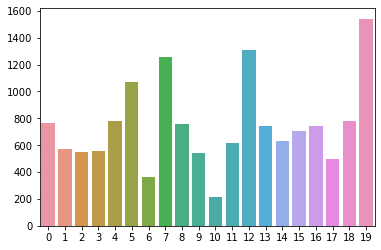

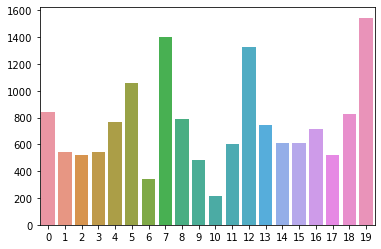

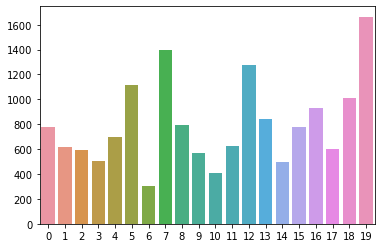

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   fragment_id  16000 non-null  int64
 1   behavior_id  16000 non-null  int64
dtypes: int64(2)
memory usage: 250.1 KB


In [45]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

def acc_combo(y, y_pred):
    # 数值ID与行为编码的对应关系
    mapping = {
        0: 'A_1', 1: 'B_2', 2: 'A_3', 3: 'A_4', 4: 'B_3', 5: 'C_5', 6: 'C_2', 7: 'A_5', 8: 'B_1', 
        9: 'C_1', 10: 'A_2', 11: 'C_3',12: 'B_5', 13: 'B_4', 14: 'C_4', 
        15: 'D_6', 16: 'E_7', 17: 'F_8', 18: 'G_9', 19: 'H_0'
              }
    # 将行为ID转为编码
    code_y, code_y_pred = mapping[y], mapping[y_pred]
    if code_y == code_y_pred: #编码完全相同得分1.0
        return 1.0
    elif code_y.split("_")[0] == code_y_pred.split("_")[0]: #编码仅字母部分相同得分1.0/7
        return 1.0/7
    elif code_y.split("_")[1] == code_y_pred.split("_")[1]: #编码仅数字部分相同得分1.0/3
        return 1.0/3
    else:
        return 0.0

train_y = y
labels = np.argmax(proba_t[:,:20], axis=1)
oof_y = np.argmax(proba_oof[:,:20], axis=1)
print(round(accuracy_score(train_y, oof_y), 5))
scores = sum(acc_combo(y_true, y_pred) for y_true, y_pred in zip(train_y, oof_y)) / oof_y.shape[0]
print(round(scores, 5))
data_path = '../data/'
sub = pd.read_csv(data_path+'submit_example.csv')
sub['behavior_id'] = labels

vc = pd.Series(train_y).value_counts().sort_index()
sns.barplot(vc.index, vc.values)
plt.show()

vc = pd.Series(oof_y).value_counts().sort_index()
sns.barplot(vc.index, vc.values)
plt.show()

vc = sub['behavior_id'].value_counts().sort_index()
sns.barplot(vc.index, vc.values)
plt.show()
sub.to_csv('LSTM%.5f.csv' % scores, index=False)
sub.info()
